# Data Preparation

In [1]:
from pathlib import Path
from IPython.display import display

import numpy as np
import pandas as pd

import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
import matplotlib.pyplot as plt

from tqdm import tqdm

pd.set_option('max_columns', None)

In [2]:
df = pd.read_csv(Path(r'private/data.csv'), sep='\t')

 Let's retrieve the most useful column for our analysis like:
 * related to music features
 * to classify it (name, etc...)
 * release date (could be related to a specific era)

In [3]:
feat = [
    'danceability',
    'energy',
    'loudness',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
]

Let's have a general view of the kind of music I listen to:
* I add **duration** and **popularity** for this graph
* **key** will not be use as it is a form of grouping

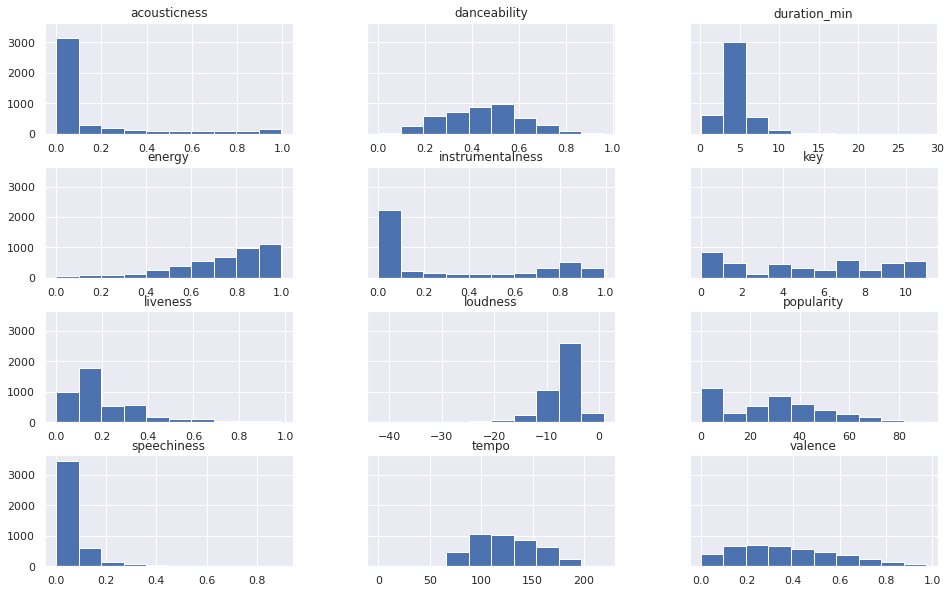

In [4]:
df[feat+['duration_min', 'popularity', 'key']].hist(sharey=True, figsize=(16, 10));

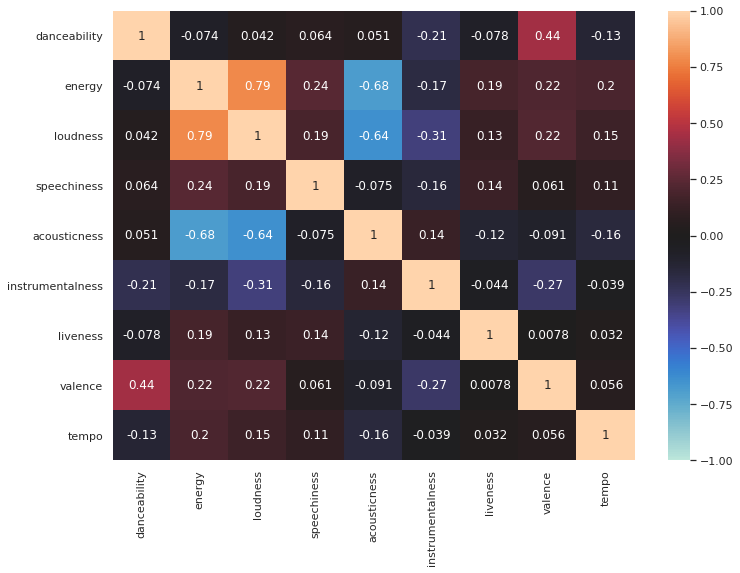

In [5]:
sns.heatmap(df[feat].corr(), annot=True, vmin=-1, vmax=1, center=0);

# Dimensionality Reduction and Clustering

## Dimensionality Reduction
There is 10 audio features given by Spotify, to view our songs in 1 view, I will apply a dimensionality reduction algorithm to project in a 2D plane.
After that I will cluster on this plane.
Then we can see if the clustering make sense...

I use Mahalanobis distance metric because my data has:
- different variance and repartition shape
- low correlation (exept **loudness** and **energy**)

In [6]:
from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import TSNE
from umap import UMAP

def mdl_fit_transform_precompute(metric, mdl, df=df[feat]):
    matrix_dist = squareform(pdist(df, metric=metric))
    proj = mdl.fit_transform(matrix_dist)
    plt.figure();
    sns.scatterplot(proj[:,0], proj[:,1]).set_title(metric);
    return proj

### UMAP
I think UMAP shoul be easier to tune (from previous experiment) and has more affinity for high dimension features.  
Moreover it is said to keep the global structures

UMAP(metric='precomputed', min_dist=0, n_epochs=1000, random_state=0, verbose=1)
Construct fuzzy simplicial set
Sat Jul  4 03:40:46 2020 Finding Nearest Neighbors
Sat Jul  4 03:40:53 2020 Finished Nearest Neighbor Search
Sat Jul  4 03:40:58 2020 Construct embedding
	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs
	completed  500  /  1000 epochs
	completed  600  /  1000 epochs
	completed  700  /  1000 epochs
	completed  800  /  1000 epochs
	completed  900  /  1000 epochs
Sat Jul  4 03:41:50 2020 Finished embedding


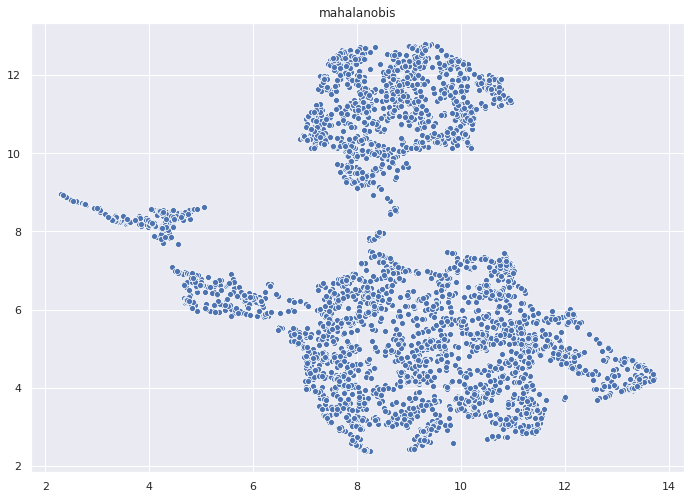

In [9]:
mdl_umap = UMAP(
    n_neighbors=15,
    min_dist=0,
    metric='precomputed',
    n_epochs=1000,
    verbose=1,
    random_state=0
)
proj_umap = mdl_fit_transform_precompute('mahalanobis', mdl_umap);

## Clustering
### HDBSCAN
I fine-tuned HDBSCAN with the min_cluster_size and let min_samples be found
* min_cluster_size should be similar to an album size (10-20) or a playlist size (50-100)
* min_samples is used to have a more or less conservative clustering (more outliers or less for each clusters)

In [11]:
from hdbscan import HDBSCAN

def cluster_analysis(clusters, proj):

    _, axes = plt.subplots(1, 2, figsize=(16,8))
    clusters.value_counts().plot(kind='barh', ax=axes[0], title='count of songs per clusters');
    sns.scatterplot(
        x=proj[:,0],
        y=proj[:,1],
        hue=clusters,
        legend='full',
        palette=sns.color_palette('husl', len(set(clusters))),
        edgecolor=None,
        ax=axes[1]
    ).legend(loc='center right', bbox_to_anchor=(1.5, 0.5), ncol=1).set_title('Projection')

def cluster_analysis_detail(clusters, df=df):
    df['clusters'] = clusters

    # Draw a dot plot with "error" bars
    with sns.axes_style("whitegrid"):
        g = sns.PairGrid(df, x_vars=feat, y_vars='clusters', aspect=.25, height=12);
        g.map(sns.pointplot, join=False, palette="dark", orient='h');

        # Use semantically meaningful titles for the columns
        titles = [s.capitalize() for s in feat]

        for ax, title in zip(g.axes.flat, titles):
            # Set a different title for each axes
            ax.set(title=title)

            # Make the grid horizontal instead of vertical
            ax.xaxis.grid(False)
            ax.yaxis.grid(True)

        g.fig.subplots_adjust(wspace=.02, hspace=.02);

100%|██████████| 90/90 [00:27<00:00,  3.27it/s]


Text(0.5, 1.0, '# clusters depending on hyperparameter')

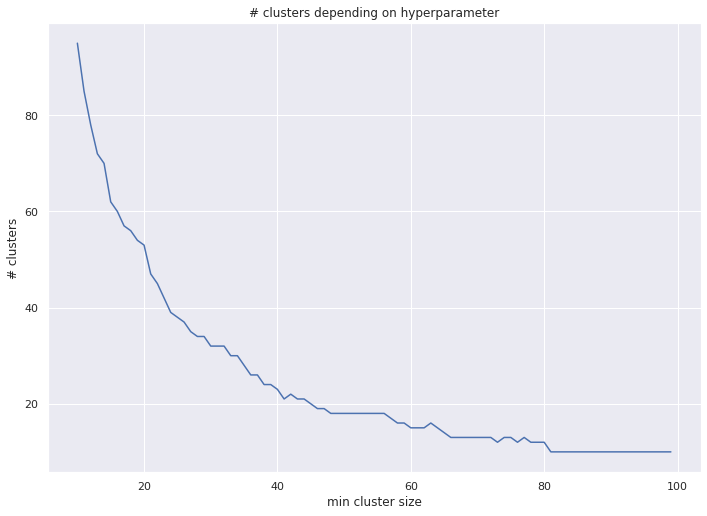

In [12]:
clusters_umap_size = []

for min_cluster_size in tqdm(range(10, 100)):
    clusters_umap = HDBSCAN(min_cluster_size=min_cluster_size, cluster_selection_method='leaf').fit_predict(proj_umap)
    clusters_umap_size.append(len(set(clusters_umap)))

plt.plot(list(range(10,100)), clusters_umap_size)
plt.xlabel('min cluster size')
plt.ylabel('# clusters')
plt.title('# clusters depending on hyperparameter')

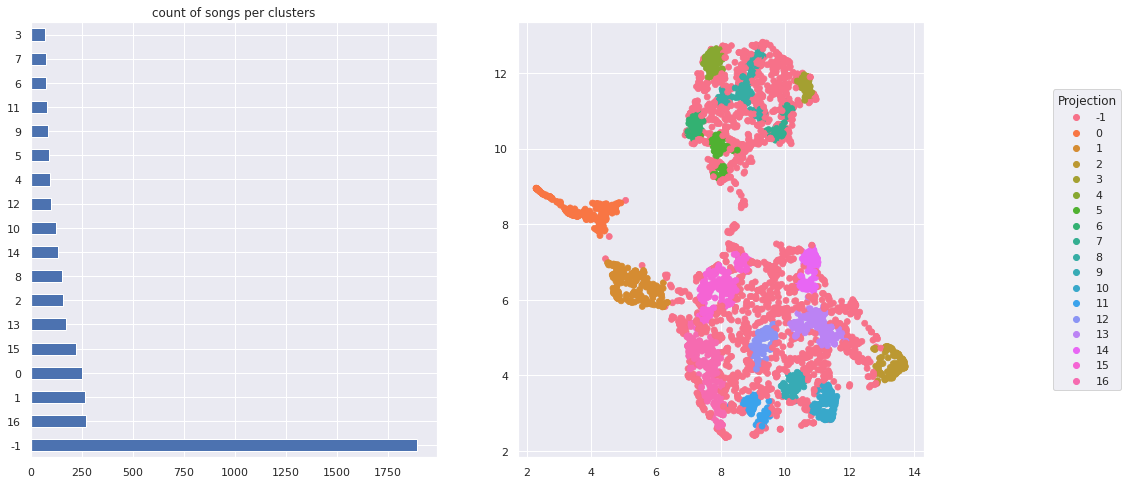

In [13]:
clusters_umap = pd.Series(HDBSCAN(min_cluster_size=50, min_samples=None, cluster_selection_method='leaf').fit_predict(proj_umap))
cluster_analysis(clusters_umap, proj_umap)

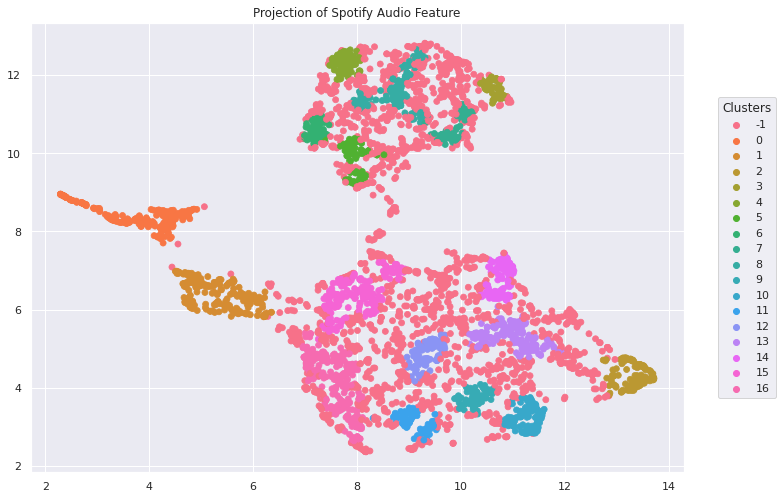

In [14]:
sns.scatterplot(
    x=proj_umap[:,0],
    y=proj_umap[:,1],
    hue=clusters_umap,
    legend='full',
    palette=sns.color_palette('husl', len(set(clusters_umap))),
    edgecolor=None,
).legend(loc='center right', bbox_to_anchor=(1.15, 0.5), ncol=1).set_title('Clusters')

plt.title('Projection of Spotify Audio Feature');

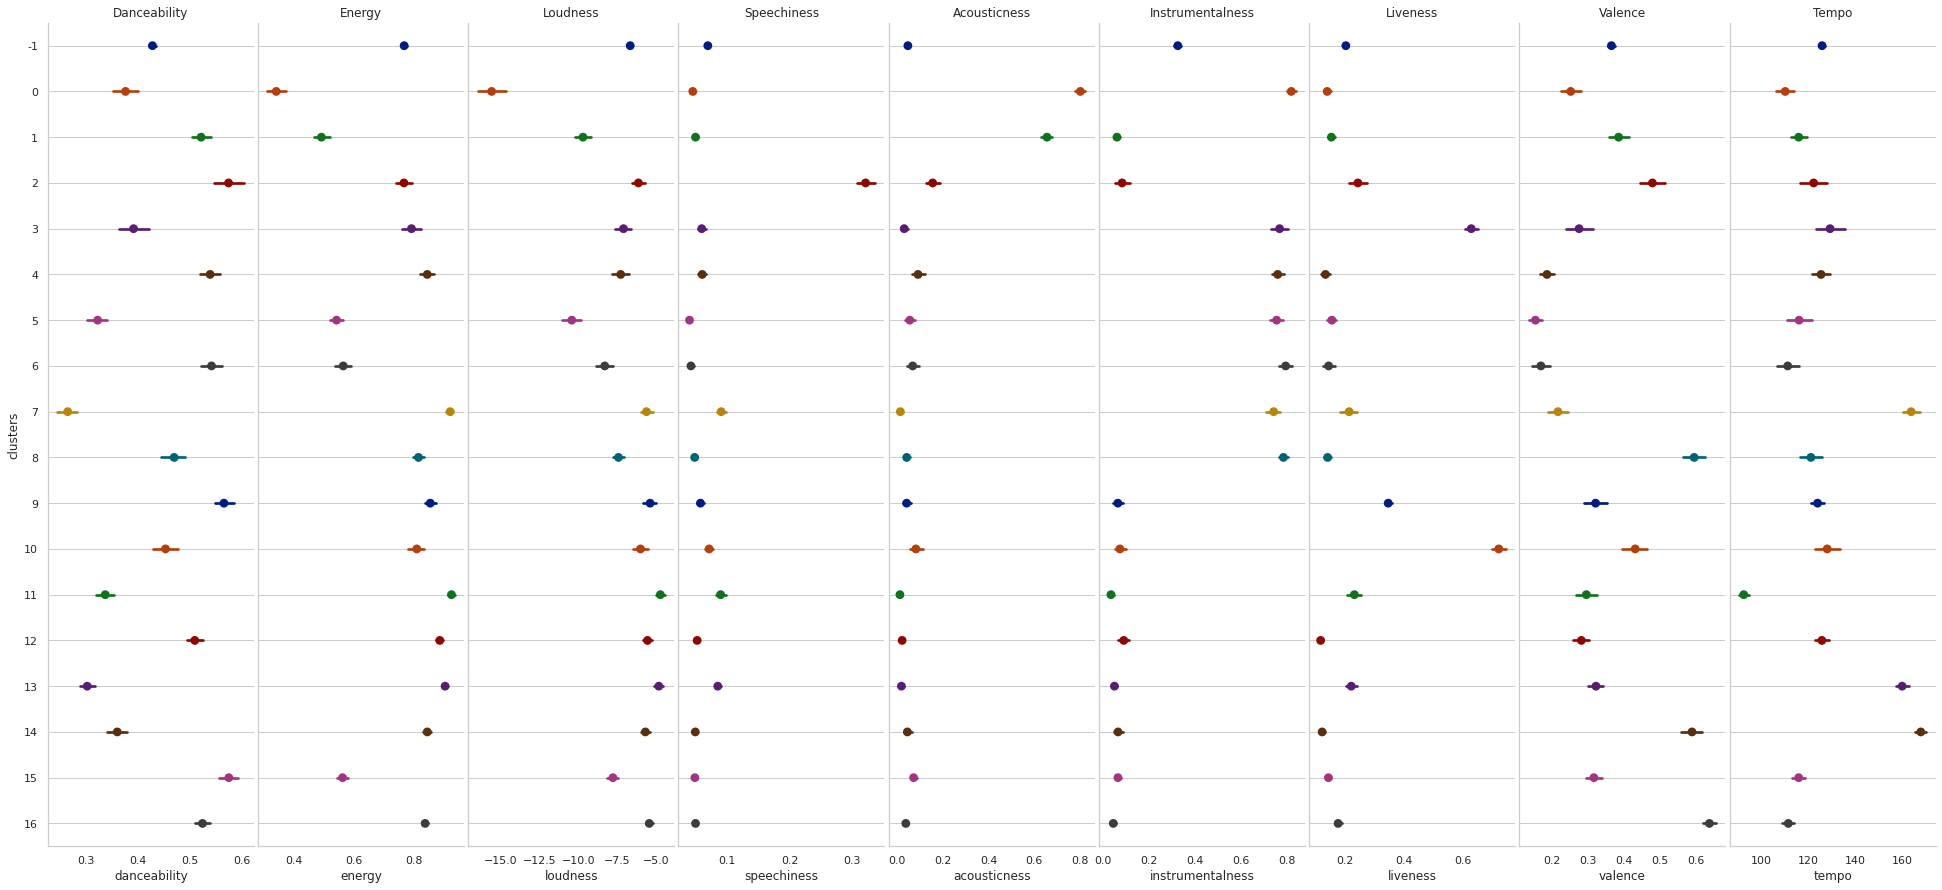

In [15]:
cluster_analysis_detail(clusters_umap)

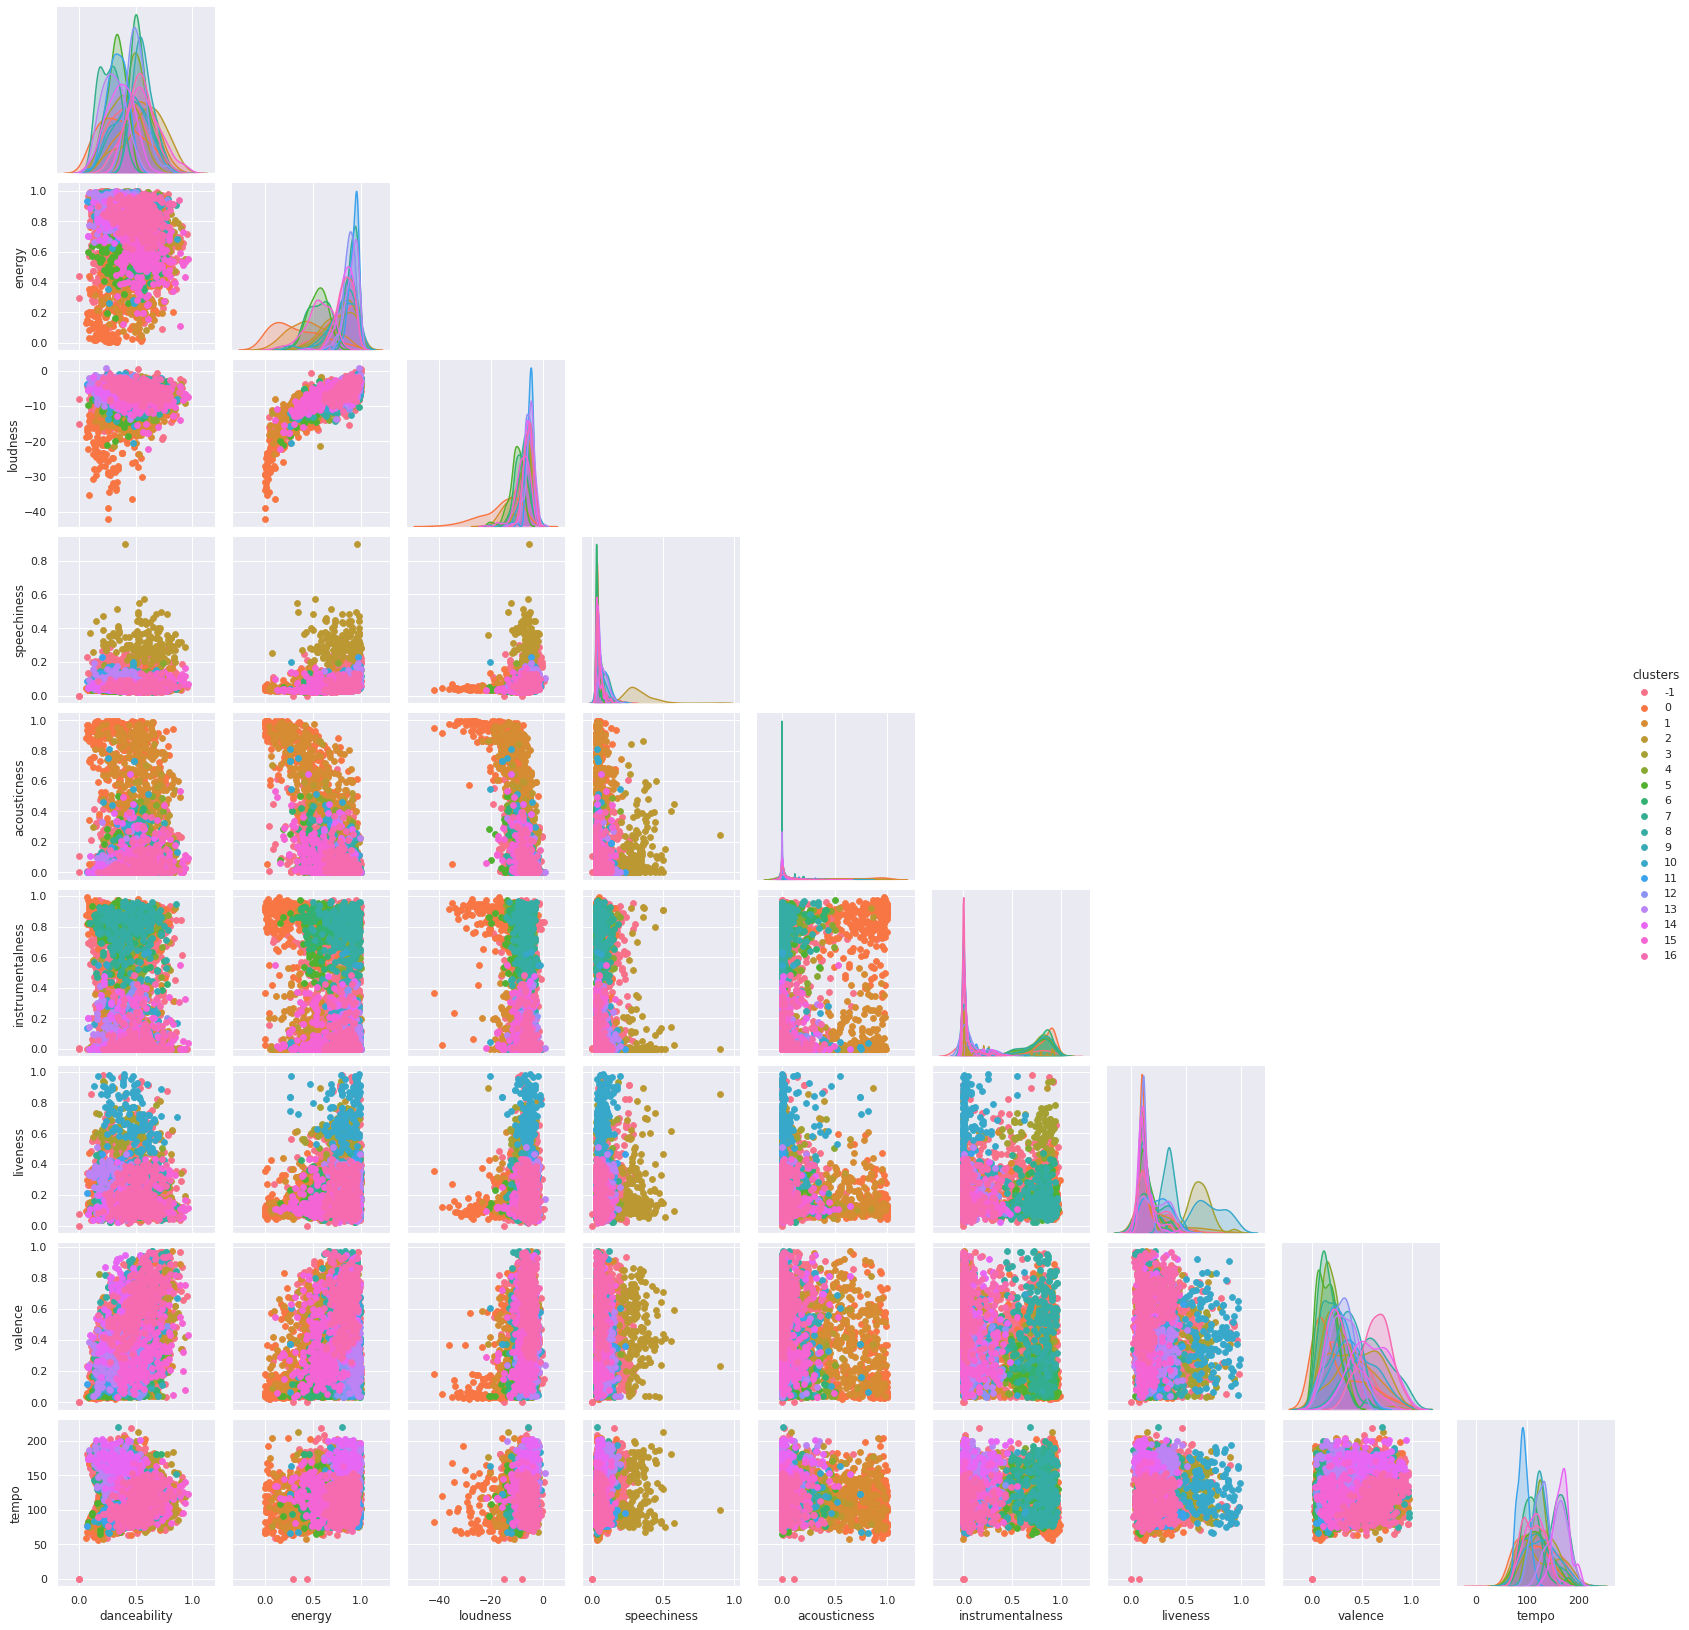

In [16]:
df['clusters'] = clusters_umap

sns.pairplot(
    df[feat+['clusters']],
    hue='clusters',
    diag_kind='kde',
    corner=True,
    palette=sns.color_palette('husl', len(set(clusters_umap))),
    plot_kws={'edgecolor':None,},
);

In [17]:
df['proj_x'] = proj_umap[:,0]
df['proj_y'] = proj_umap[:,1]
df['clusters'] = clusters_umap

# Visualization
Let's see if those clusters make sense by printing each 10 most popular songs  
An interactive plot with px would help see where the songs are in the projection and what they are

In [18]:
df['hover_text'] = df.apply(
    lambda x:
        f'<br>'+
        f'Full Song: <a href="{x["external_urls.spotify"]}">Play</a><br>' +
        f'Album: {x["album.name"]}<br>' +
        # f'Genres: {x["artists.genres"]}<br>'+
        # f'Super Genres: {x["artists.supergenres"]}<br>' +
        f'Super Genre 1: {x["artists.supergenre_1"]}<br>',
    axis=1
)

df['fullname'] = df.apply(
    lambda x: f'{x["name"]}, {x["artists.name"]}<br>',
    axis=1
)

df['size'] = df['popularity'].apply(lambda x: np.log(x+1))

col = feat+[
    'clusters',
    'proj_x',
    'proj_y',
    'hover_text',
    'fullname',
    'size',
    'preview_url',
    'popularity'
]

# My most popular songs in a 2D plot

After I projected my 4000+ liked songs in my Spotify playlist, I projected it with UMAP and clustered with HDBSCAN.
Those are the top3 most popular songs in each of the clusters.

Below is a plot done with Plotly, where I embedded a link to a song preview file.

As such you can as well hover over the points to know which song it is or click on it to listen to it.

In [21]:
# count of most popular songs to analyse
top_n = 3

In [22]:
df_top = df[col].groupby('clusters').apply(
    lambda x: x.sort_values('popularity', ascending=False).head(top_n)
)

In [23]:
from plotly.offline import download_plotlyjs, init_notebook_mode
import plotly.express as px
init_notebook_mode(connected=True)

fig = px.scatter(
    df_top,
    x='proj_x',
    y='proj_y',
    hover_name='fullname',
    hover_data=['hover_text'],
    text=df_top['preview_url'].map(lambda x: f'<a href="{x}">Play</a>'),
    size='size',
    color=df_top['clusters'].astype(str),
    color_discrete_sequence=px.colors.qualitative.Vivid,
    title=f'my top {top_n} songs per cluster'
)

fig.update_layout(
    autosize=False,
    width=1000,
    height=800,
)